<a href="https://colab.research.google.com/github/minzee09/food-nutrition-image-recognizer/blob/main/resnet_food_nutrition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
# food101(음식 이미지) 데이터셋
food101_dataset = tfds.load('food101', split='train', as_supervised=True)

In [ ]:
# 데이터 전처리 함수 정의
def preprocess_image_with_nutrition(image, label):
    image = tf.image.resize(image, [224, 224])
    image = preprocess_input(image)

    # label을 문자열로 변환
    label_str = tf.strings.lower(tf.strings.as_string(label))

    # 영양 성분 정보 매핑
    nutrition_mapping = {
        'bibimbap': [18.3, 98.7, 24.6, 22],
        'apple_pie': [9, 3, 0, 0],
        'baby_back_ribs': [14.43, 10.43, 84.72, 55.61],
        'beef_carpaccio': [7.93, 12.18, 14.9, 9.64]
    }

    default_nutrition = [0, 0, 0, 0]
    nutritional_info = nutrition_mapping.get(label_str.numpy().decode('utf-8'), default_nutrition)
    nutritional_info = tf.constant(nutritional_info, dtype=tf.float32)

    return image, nutritional_info

In [ ]:
def preprocess_and_map(image, label):
    image, nutritional_info = tf.py_function(preprocess_image_with_nutrition, [image, label], [tf.float32, tf.float32])
    image.set_shape((224, 224, 3))
    nutritional_info.set_shape((4,))
    return image, nutritional_info

In [ ]:
# 데이터셋 매핑
food101_dataset = food101_dataset.map(preprocess_and_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
# 배치 및 셔플
batch_size = 32
food101_dataset = food101_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# ResNet50 모델 로드 및 커스터마이즈
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = tf.keras.Sequential([
    resnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])


94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# 모델 컴파일
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [ ]:
# 모델 학습
model.fit(food101_dataset, epochs=5)

Epoch 1/5
2368/2368 [==============================] - 1133s 458ms/step - loss: 0.0041 - accuracy: 0.2541
Epoch 2/5
2368/2368 [==============================] - 1083s 455ms/step - loss: 4.3368e-08 - accuracy: 0.1218
Epoch 3/5
2368/2368 [==============================] - 1074s 451ms/step - loss: 4.3630e-09 - accuracy: 0.2267
Epoch 4/5
2368/2368 [==============================] - 1053s 442ms/step - loss: 4.3350e-09 - accuracy: 0.2211
Epoch 5/5
2368/2368 [==============================] - 1040s 437ms/step - loss: 1.2012e-09 - accuracy: 0.2236


In [ ]:
import numpy as np

# food101 데이터셋 테스트 셋 로드
food101_test_dataset = tfds.load('food101', split='validation', as_supervised=True)

# 데이터셋 매핑 함수 재사용
food101_test_dataset = food101_test_dataset.map(preprocess_and_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
food101_test_dataset = food101_test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# 모델 평가
test_loss, test_accuracy = model.evaluate(food101_test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# 샘플 예측
for image, label in food101_test_dataset.take(1):
    predictions = model.predict(image)
    for i in range(5):  # 상위 5개 샘플에 대해 예측 결과 출력
        print(f"Image {i+1}")
        print(f"True Label: {label.numpy()[i]}")
        print(f"Predicted Nutrition Info: {predictions[i]}")

790/790 [==============================] - 175s 219ms/step - loss: 1.1723e-09 - accuracy: 8.3168e-04
Test Loss: 1.172332786403274e-09
Test Accuracy: 0.0008316831663250923
1/1 [==============================] - 1s 943ms/step
Image 1
True Label: [0. 0. 0. 0.]
Predicted Nutrition Info: [-6.0738012e-07 -6.2162138e-07 -5.0760264e-07  4.5299117e-07]
Image 2
True Label: [0. 0. 0. 0.]
Predicted Nutrition Info: [-6.0738012e-07 -6.2162138e-07 -5.0760264e-07  4.5299117e-07]
Image 3
True Label: [0. 0. 0. 0.]
Predicted Nutrition Info: [-6.0738012e-07 -6.2162138e-07 -5.0760264e-07  4.5299117e-07]
Image 4
True Label: [0. 0. 0. 0.]
Predicted Nutrition Info: [-6.0738012e-07 -6.2162138e-07 -5.0760264e-07  4.5299117e-07]
Image 5
True Label: [0. 0. 0. 0.]
Predicted Nutrition Info: [-6.0738012e-07 -6.2162138e-07 -5.0760264e-07  4.5299117e-07]


1/1 [==============================] - 0s 70ms/step


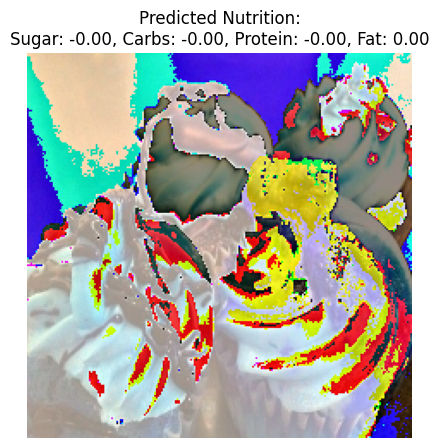

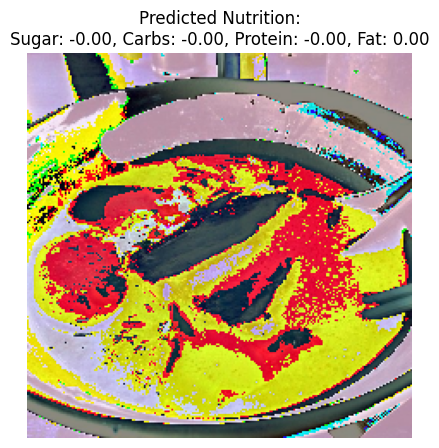

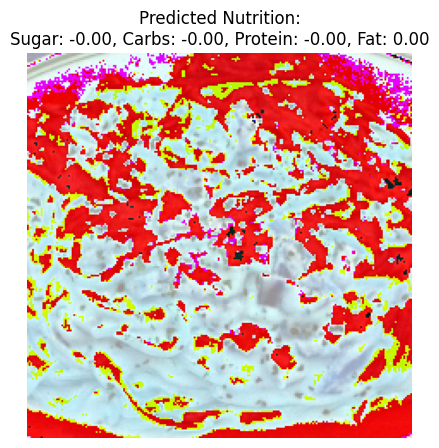

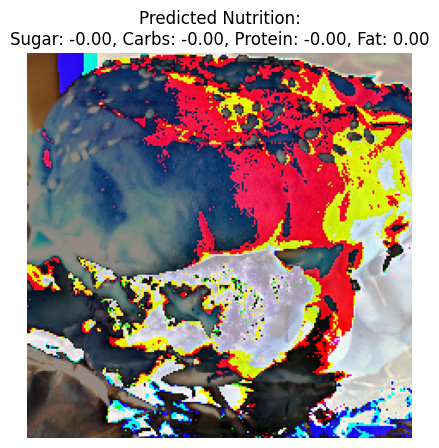

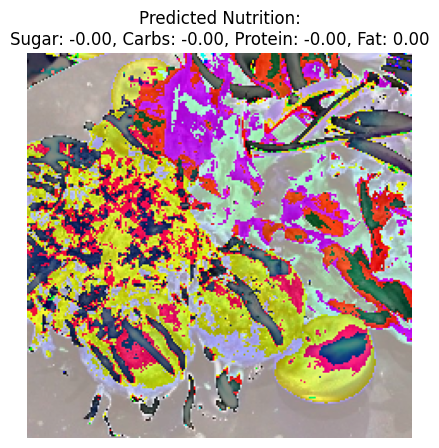

In [ ]:
#시각화
import matplotlib.pyplot as plt

# 테스트 데이터셋 로드 및 전처리
food101_test_dataset = tfds.load('food101', split='validation', as_supervised=True)
food101_test_dataset = food101_test_dataset.map(preprocess_and_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
food101_test_dataset = food101_test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# 샘플 이미지와 예측된 영양 성분 정보를 출력
def plot_image_and_nutrition(image, true_nutrition, predicted_nutrition):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Predicted Nutrition:\nSugar: {:.2f}, Carbs: {:.2f}, Protein: {:.2f}, Fat: {:.2f}".format(
        predicted_nutrition[0], predicted_nutrition[1], predicted_nutrition[2], predicted_nutrition[3]))
    plt.show()

# 모델 평가 및 예측 결과 출력
for images, true_nutritions in food101_test_dataset.take(1):
    predictions = model.predict(images)
    for i in range(5):  # 상위 5개 샘플에 대해 예측 결과 출력
        image = images[i].numpy().astype("uint8")
        true_nutrition = true_nutritions[i].numpy()
        predicted_nutrition = predictions[i]
        plot_image_and_nutrition(image, true_nutrition, predicted_nutrition)

-----------------------------------------

예전 코드

In [ ]:
# Load the ResNet50 model pre-trained on ImageNet dataset
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# 데이터셋 매핑
food101_dataset = food101_dataset.map(preprocess_image_with_nutrition)

In [ ]:
# 배치
batch_size = 32
food101_dataset = food101_dataset.shuffle(buffer_size=len(food101_dataset)).batch(batch_size)

In [ ]:
# 모델 정의(Resnet은 X)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(food101_dataset, epochs=5)  # Adjust epochs as needed

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node cond/GatherV2_tfg_inlined_cond_0 defined at (most recent call last):
<stack traces unavailable>
indices = 90 is not in [0, 4)
	 [[{{node cond/GatherV2_tfg_inlined_cond_0}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_5093]